# Transformée en z inverse (pôles d'ordre 1 ou 2)

Les packages utilisés :

In [1]:
import sympy as sp
import numpy as np
from scipy.signal import lfilter
import matplotlib.pyplot as plt
from IPython.display import display

## Calcul symbolique avec sympy

On considère un exemple $H(z)$ de transformée en $z$, avec les zéros et les pôles (ordre 1 ou 2) sous forme littérale.

In [2]:
zm1, n = sp.symbols('z^{-1}, n')
P = sp.IndexedBase('P')
Z = sp.IndexedBase('Z')
A = sp.IndexedBase('A')
Pn = [(P[0], 0.5), (P[1], 0.9), (P[2], 0.6)]
OPn = [1, 2, 1]
Zn = [(Z[0], 0.1), (Z[1], 0.2)]
OZn = [1, 1]

Les applications numériques pourront être effectuées via la méthode **subs**.

In [3]:
H = 5
for k in range(len(Pn)):
    H = H/(1 - P[k]*zm1)**OPn[k]
for k in range(len(Zn)):
    H = H*(1 - Z[k]*zm1)**OZn[k]
display(H)
display(H.subs(Pn).subs(Zn))

5*(-z^{-1}*Z[0] + 1)*(-z^{-1}*Z[1] + 1)/((-z^{-1}*P[0] + 1)*(-z^{-1}*P[1] + 1)**2*(-z^{-1}*P[2] + 1))

5*(1 - 0.2*z^{-1})*(1 - 0.1*z^{-1})/((1 - 0.9*z^{-1})**2*(1 - 0.6*z^{-1})*(1 - 0.5*z^{-1}))

La décomposition en élément simple avec la méthode **apart**, après application numérique, ne fonctionne pas pour l'exemple considéré !

In [4]:
display(H.subs(Pn).subs(Zn).apart())

1.61812297734628*(0.02*z^{-1}**2 - 0.3*z^{-1} + 1.0)/(0.0786407766990291*z^{-1}**4 - 0.463106796116505*z^{-1}**3 + 1.0*z^{-1}**2 - 0.938511326860841*z^{-1} + 0.323624595469256)

Il faut donc effectuer la décomposition avec la forme littérale, puis réaliser l'application numérique a posteriori. On envisage juste le cas où les pôles ont un ordre de multiplicité égal à 1 ou 2.

In [5]:
tz = 0
h = 0
An = []
for k in range(len(Pn)):
    if OPn[k] == 1:
        An.append((A[k, 1],
                   (H*(1-zm1*P[k])).simplify().subs(zm1, 1/P[k]).subs(Pn).subs(Zn)))
        tz = tz + A[k, 1]/(1-zm1*P[k])
        h = h + A[k, 1]*(P[k]**n)
    elif OPn[k] == 2:
        An.append((A[k, 2],
                   (H*(1-zm1*P[k])**2).simplify().subs(zm1, 1/P[k]).subs(Pn).subs(Zn)))
        tz = tz + A[k, 2]/(1-zm1*P[k])**2
        h = h + (n+1)*A[k, 2]*(P[k]**n)
        An.append((A[k, 1],
                   ((H - (H*(1-zm1*P[k])**2).simplify().subs(zm1, 1/P[k])/(1-P[k]*zm1)**2) *
                  (1-P[k]*zm1)).expand().simplify().subs(zm1, 1/P[k]).subs(Pn).subs(Zn)))
        tz = tz + A[k, 1]/(1-zm1*P[k])
        h = h + A[k, 1]*(P[k]**n)
display(tz)
display(h)
print(An)
print(Zn)
print(Pn)

A[2, 1]/(-z^{-1}*P[2] + 1) + A[1, 1]/(-z^{-1}*P[1] + 1) + A[1, 2]/(-z^{-1}*P[1] + 1)**2 + A[0, 1]/(-z^{-1}*P[0] + 1)

(n + 1)*A[1, 2]*P[1]**n + A[0, 1]*P[0]**n + A[1, 1]*P[1]**n + A[2, 1]*P[2]**n

[(A[0, 1], -18.7500000000000), (A[1, 2], 23.3333333333333), (A[1, 1], -66.2500000000001), (A[2, 1], 66.6666666666667)]
[(Z[0], 0.1), (Z[1], 0.2)]
[(P[0], 0.5), (P[1], 0.9), (P[2], 0.6)]


Les coefficients des polynômes en $z^{-1}$ du numérateur $N(z)$ et du dénominateur $D(z)$ sont récupérés sous forme numérique selon les puissances décroissantes de $z^{-1}$.

In [6]:
N = sp.fraction(H)[0].subs(Zn)
D = sp.fraction(H)[1].subs(Pn)
coeffD = np.array(sp.Poly(D).coeffs(), dtype=float)
coeffN = np.array(sp.Poly(N).coeffs(), dtype=float)

## Calcul numérique avec la fonction **lfilter** de scipy

Les coefficients des polynômes en $z^{-1}$ du numérateur et du dénominateur sont cette fois récupérés selon les puissances croissantes de $z^{-1}$. Il n'est pas nécessaire de réaliser la décomposition en éléments simples et il suffit d'envoyer en entrée une impulsion numérique $\delta(n)$.

In [7]:
N = 25
delta = np.zeros(N)
tn = np.arange(N)
delta[0] = 1

In [8]:
an = np.flip(coeffD)
bn = np.flip(coeffN)
print(an)
print(bn)

[ 1.    -2.9    3.09  -1.431  0.243]
[ 5.  -1.5  0.1]


In [9]:
h_scipy = lfilter(bn, an, delta)

## Calcul numérique avec les résultats obtenus avec sympy

L'application numérique s'effectue à partir de l'expression littérale de $h(n)$.

In [10]:
display(h)
h_sympy = np.real(sp.lambdify(n, h.subs(Pn).subs(An), 'numpy')(tn))

(n + 1)*A[1, 2]*P[1]**n + A[0, 1]*P[0]**n + A[1, 1]*P[1]**n + A[2, 1]*P[2]**n

## Bilan

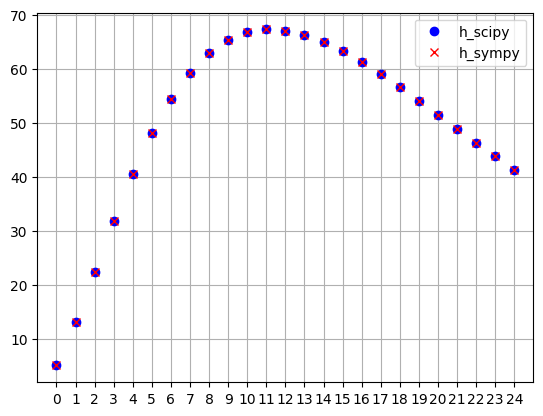

In [11]:
plt.plot(tn, h_scipy, 'bo', label='h_scipy')
plt.plot(tn, h_sympy, 'rx', label='h_sympy')
plt.grid('on')
plt.xlim([-1, N])
plt.xticks(np.arange(N))
plt.legend()
plt.show()